In [17]:
import os
import sys

# Move up to the correct project root
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Updated Python path:", sys.path)  # Debugging check

Updated Python path: ['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\python312.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env', '', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env\\Lib\\site-packages', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env\\Lib\\site-packages\\win32', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\D

In [4]:
!jupyter nbconvert --to script "DQN_Agent.ipynb"



[NbConvertApp] Converting notebook DQN_Agent.ipynb to script
[NbConvertApp] Writing 11979 bytes to DQN_Agent.py


In [18]:
from Environment.environment import TradingEnv

In [19]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from collections import Counter

# Set paths for data so that other notebooks can import functions without problems

In [20]:
# Get the current working directory of the notebook

def get_base_dir():
    try:
        return os.path.dirname(os.path.abspath(__file__))  # For .py files
    except NameError:
        return os.getcwd()
    
BASE_DIR = get_base_dir()

# Paths to your data and scaler
train_data_path = os.path.join(BASE_DIR, '../../Transform_data/stand_data/2023-2018_stand_data.csv')
test_data_path = os.path.join(BASE_DIR, '../../Transform_data/stand_data/2025-2024_stand_data.csv')
scaler_path = os.path.join(BASE_DIR, '../../Transform_data/scaler.pkl')


In [21]:
seed = 42
SEED  = seed % (2**32 - 1)
print(f"SEED: {SEED}")

SEED: 42


In [22]:
# -------------------------------
# CSV Daten einlesen
# -------------------------------
train_data = pd.read_csv(train_data_path)
train_data.drop('datetime', axis=1, inplace=True)

test_data = pd.read_csv(test_data_path)
test_data.drop('datetime', axis=1, inplace=True)

if train_data is not None and test_data is not None:
    print("Daten erfolgreich eingelesen")


Daten erfolgreich eingelesen


In [23]:
# Für Hyperparameter-Tuning nutzen wir test_data als Validierungsdatensatz.
valid_data = test_data.copy()

# -------------------------------
# Evaluation Helper Function
# -------------------------------
def evaluate_agent(model, env, n_eval_episodes=5):
    """
    Evaluate the model over a number of episodes.
    Returns the average cumulative reward.
    """
    episode_rewards = []
    for _ in range(n_eval_episodes):
        # Handle reset return for compatibility with gym vs. gymnasium APIs
        reset_result = env.reset()
        if isinstance(reset_result, tuple):
            obs, info = reset_result
        else:
            obs = reset_result
        done = False
        total_reward = 0.0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            step_result = env.step(action)
            # Check length to handle different API outputs
            if len(step_result) == 5:
                obs, reward, done, truncated, info = step_result
            else:
                obs, reward, done, info = step_result
            total_reward += reward
        episode_rewards.append(total_reward)
    return np.mean(episode_rewards)

In [24]:
# -------------------------------
# Hyperparameter Tuning with Optuna
# -------------------------------
def objective(trial):
    # Sample hyperparameters using updated Optuna functions
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    gamma = trial.suggest_float("gamma", 0.90, 0.9999)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    
    # Create the training environment using train_data
    env_train = DummyVecEnv([lambda: TradingEnv(
        data=train_data,
        initial_cash=10_000,
        window_size=336,
        scaler_path=scaler_path,
        default_seed=SEED
    )])
    
    # Create the validation environment using valid_data
    env_valid = DummyVecEnv([lambda: TradingEnv(
        data=valid_data,
        initial_cash=10_000,
        window_size=336,
        scaler_path=scaler_path,
        default_seed=SEED
    )])

    
    # Initialize the DQN model with sampled hyperparameters
    model = DQN(
        "MlpPolicy",
        env_train,
        learning_rate=learning_rate,
        gamma=gamma,
        batch_size=batch_size,
        verbose=0,
        seed=SEED,
        buffer_size=100_000
    )
    
    # Train the model for a fixed number of timesteps
    model.learn(total_timesteps=5000, log_interval=1)
    
    # Evaluate the trained model on the validation environment
    mean_reward = evaluate_agent(model, env_valid, n_eval_episodes=5)
    return mean_reward

In [25]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50)
# print("Best hyperparameters:", study.best_trial.params)

In [26]:
# -------------------------------
# TradingEnv erstellen (Final Environment using train_data)
# -------------------------------
env = TradingEnv(
    data=train_data,
    initial_cash=10_000,
    window_size=336,
    scaler_path=scaler_path,
    default_seed=SEED
)

if env is not None:
    print("Environment created successfully")

Seed in the environment: 42
Environment created successfully


In [27]:
# -------------------------------
# DQN-Agenten initialisieren using Best Hyperparameters
# -------------------------------
model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    seed=SEED,
    buffer_size=50_000,
    learning_rate=0.0008676988081645593,
    gamma=0.9567540210286709,
    batch_size=256
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [28]:
# -------------------------------
# Training
# -------------------------------
model.learn(
    total_timesteps=10000, 
    log_interval=1
)

# Speichere das trainierte Modell
model.save("model_without_buffer", exclude=["replay_buffer"])


Seed in the environment: 42


Seed in the environment: 42


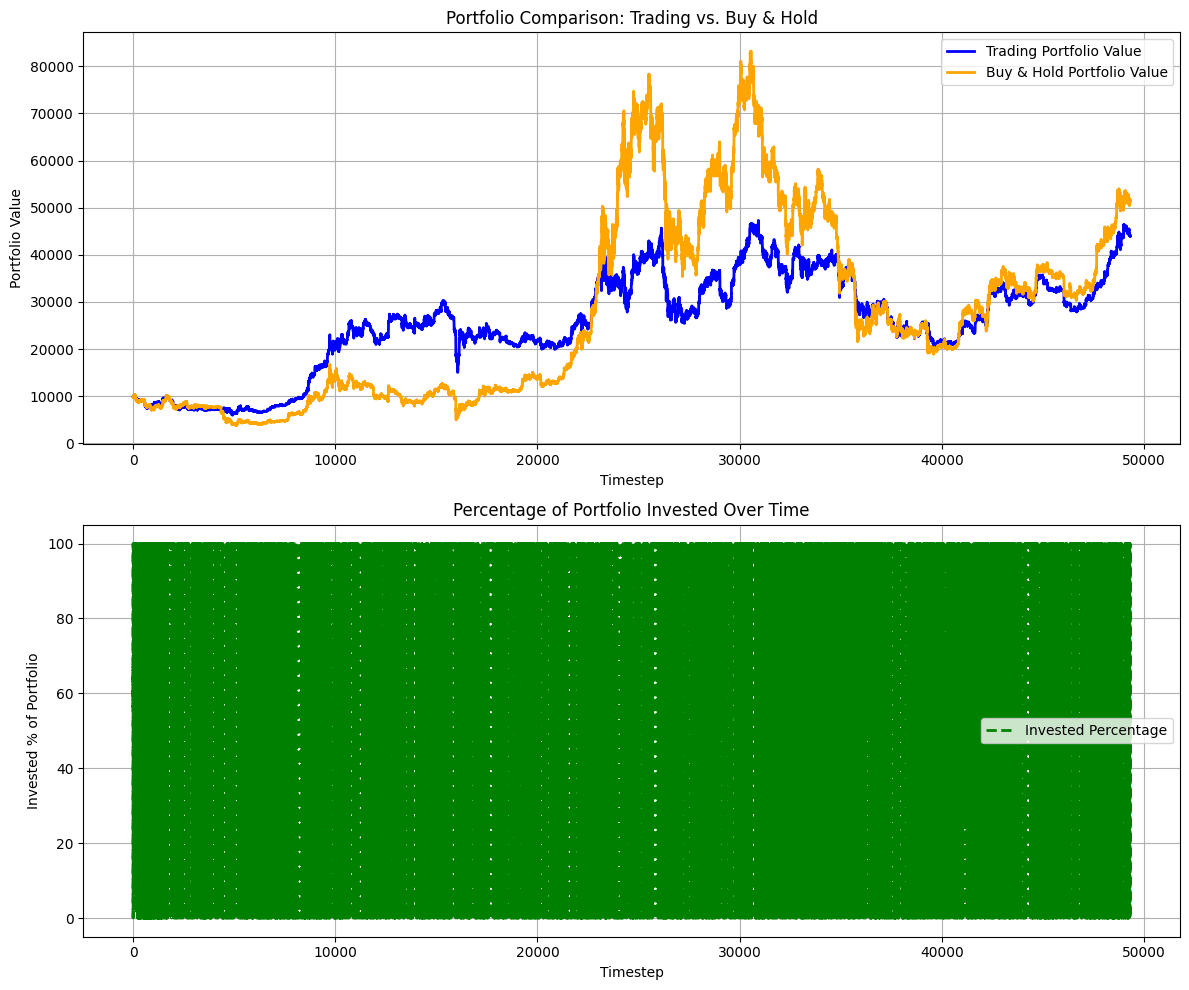

[4, 0, 0, 1, 5, 5, 1, 5, 8, 8, 0, 8, 2, 2, 2, 0, 3, 0, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 3, 5, 5, 1, 3, 7, 0, 3, 4, 0, 5, 5, 5, 1, 5, 1, 1, 2, 2, 5, 5, 1, 1, 1, 5, 1, 1, 5, 3, 3, 0, 5, 5, 5, 5, 5, 1, 1, 1, 3, 1, 1, 1, 5, 5, 5, 3, 5, 3, 5, 4, 5, 5, 7, 3, 5, 5, 7, 5, 1, 1, 3, 4, 3, 3, 7, 3, 3, 4, 3, 4, 4, 7, 7, 3, 5, 5, 5, 3, 5, 7, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 7, 3, 7, 5, 3, 7, 3, 3, 3, 3, 7, 4, 5, 3, 3, 3, 3, 7, 5, 5, 5, 3, 3, 7, 7, 7, 3, 3, 5, 0, 5, 5, 1, 0, 5, 5, 0, 5, 5, 3, 3, 0, 3, 3, 3, 3, 3, 7, 5, 4, 4, 0, 5, 5, 3, 3, 7, 3, 7, 7, 3, 3, 7, 7, 3, 3, 5, 3, 3, 7, 7, 3, 3, 3, 3, 7, 3, 7, 7, 3, 3, 2, 7, 3, 3, 6, 3, 3, 4, 3, 7, 4, 4, 4, 3, 7, 3, 7, 7, 3, 8, 7, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 8, 4, 7, 8, 1, 2, 8, 3, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 7, 7, 3, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 2, 2, 2, 3, 2, 2, 8, 2, 2, 8, 8, 3, 4, 4, 4, 8, 4, 8, 8, 8, 2, 2, 0, 2, 8, 

In [29]:
# -------------------------------
# Testlauf: Den trainierten Agenten in einer Episode ausführen (Training Environment)
# -------------------------------
training_env = env

reset_result = training_env.reset(seed=SEED)
if isinstance(reset_result, tuple):
    obs, info = reset_result
else:
    obs = reset_result
done = False

# Liste der Aktionen
action_list = []

while not done:
    action, _states = model.predict(obs, deterministic=True)
    action = int(action)  # oder: action = action.item()
    step_result = training_env.step(action)
    if len(step_result) == 5:
        obs, reward, done, truncated, info = step_result
    else:
        obs, reward, done, info = step_result
    action_list.append(action)

# Rendern des aktuellen Zustands (z.B. als Plot)
training_env.render(mode='human')
print(action_list)

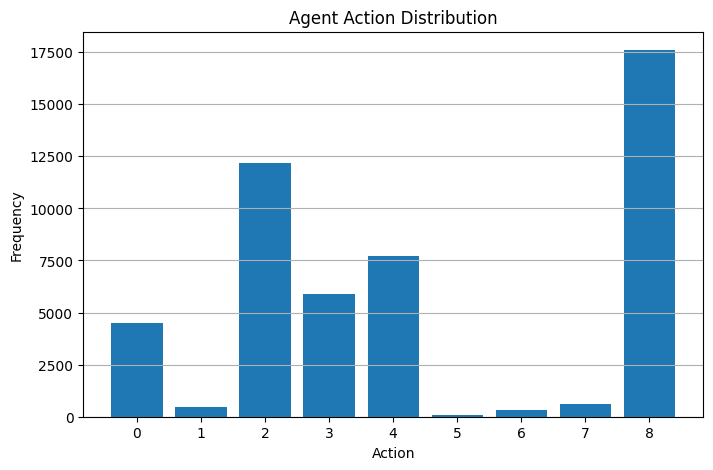

In [30]:

# -------------------------------
# Plot Action Distribution
# -------------------------------
action_counts = Counter(action_list)
actions = list(range(9))
counts = [action_counts.get(action, 0) for action in actions]

plt.figure(figsize=(8, 5))
plt.bar(actions, counts, tick_label=actions)
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Agent Action Distribution")
plt.grid(axis='y')
plt.show()

Seed in the environment: 42
Seed in the environment: 42


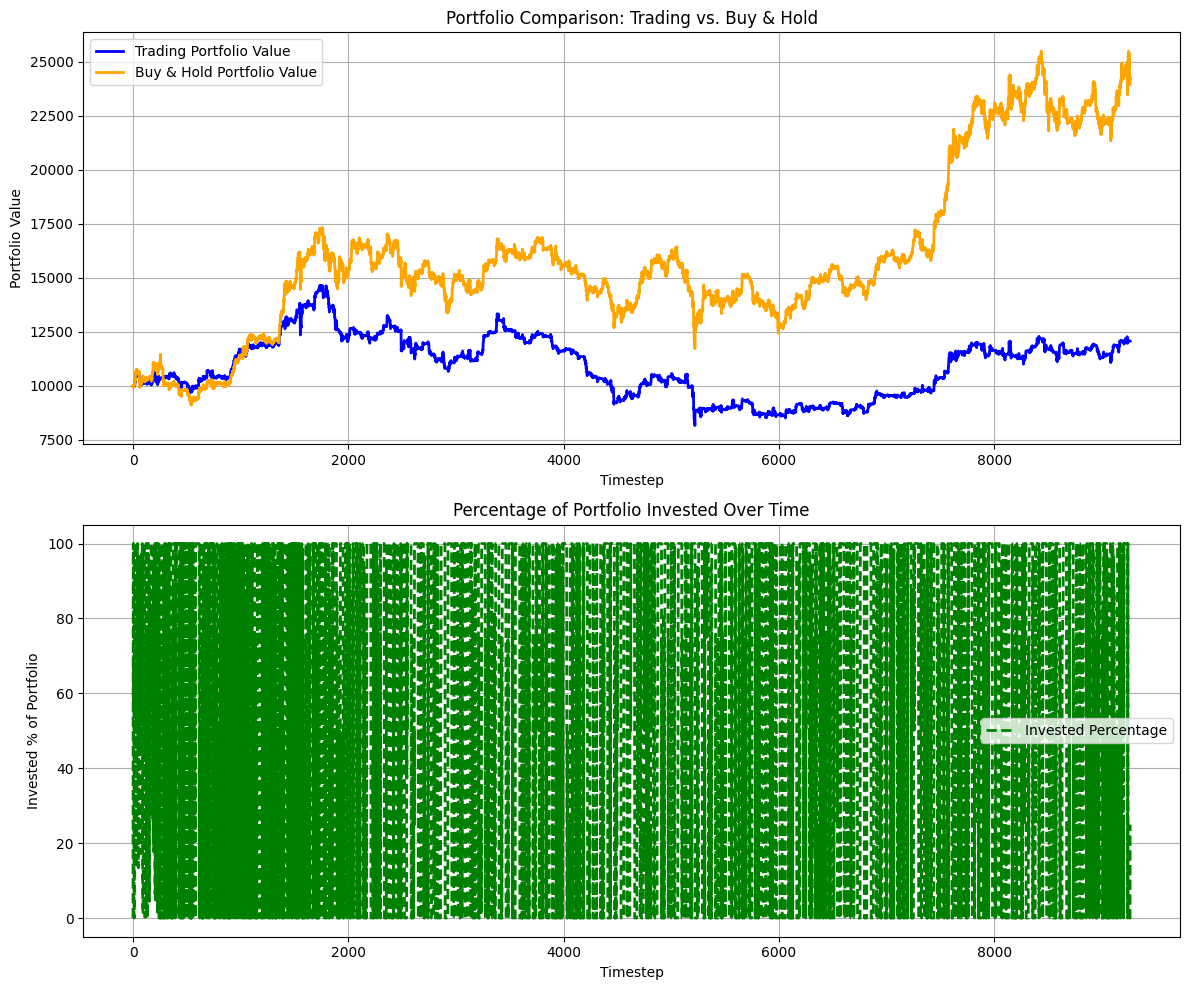

[4, 0, 0, 1, 5, 5, 1, 5, 8, 8, 0, 8, 2, 2, 2, 0, 3, 0, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 2, 1, 5, 3, 1, 5, 1, 3, 4, 3, 3, 5, 5, 5, 5, 5, 5, 5, 1, 1, 2, 2, 1, 5, 5, 1, 1, 1, 5, 5, 3, 3, 0, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 3, 5, 5, 3, 3, 5, 5, 4, 5, 5, 7, 7, 5, 5, 5, 5, 1, 1, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 7, 7, 7, 7, 5, 5, 5, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 7, 7, 7, 7, 7, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 3, 3, 7, 5, 7, 3, 2, 5, 5, 5, 1, 1, 5, 5, 5, 0, 3, 5, 3, 3, 3, 3, 3, 3, 3, 4, 4, 2, 4, 1, 5, 5, 2, 3, 3, 3, 3, 7, 3, 7, 3, 3, 7, 5, 3, 5, 3, 3, 5, 7, 3, 3, 3, 3, 3, 7, 7, 3, 7, 7, 4, 7, 7, 3, 3, 4, 3, 4, 3, 4, 4, 4, 4, 3, 7, 4, 7, 7, 7, 3, 7, 7, 3, 3, 3, 3, 3, 3, 3, 5, 1, 1, 1, 1, 8, 4, 3, 3, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 4, 3, 3, 3, 3, 3, 8, 8, 8, 0, 8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 0, 3, 7, 8, 8, 8, 8, 8, 3, 0, 3, 3, 3, 2, 2, 2, 8, 0, 8, 8, 3, 8, 8, 2, 2, 2, 8, 2, 2, 8, 8, 7, 2, 2, 3, 2, 4, 3, 8, 

In [31]:
# -------------------------------
# Testlauf: Den trainierten Agenten in einer Episode ausführen
# -------------------------------
test_env = TradingEnv(
    data=test_data,
    initial_cash=10_000,
    window_size=336,
    scaler_path=scaler_path,
    default_seed=SEED
)

obs, info = test_env.reset(seed=SEED)
done = False

# Liste der actionen
action_list = []

while not done:
    # Bestimme die Aktion (deterministisch)
    action, _states = model.predict(obs, deterministic=True)
    action = int(action)  # oder: action = action.item()
    obs, reward, done, truncated, info = test_env.step(action)
    action_list.append(action)

# Hier wird der Zustand gerendert (z.B. als Plot). Du kannst den Render-Modus anpassen.
test_env.render(mode='human')
print(action_list)

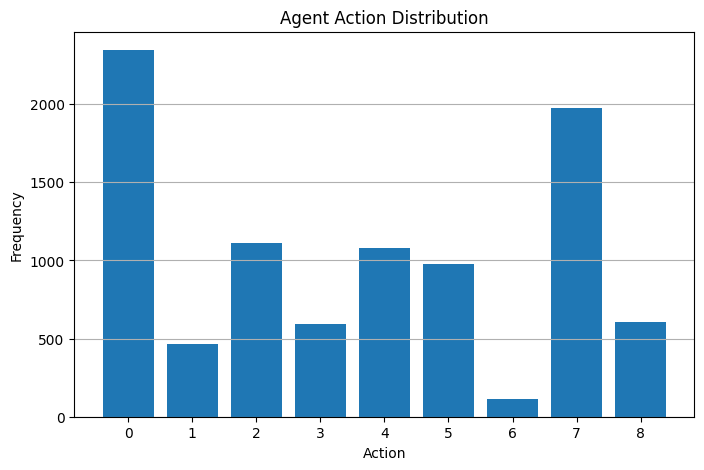

In [16]:

# -------------------------------
# Plot Action Distribution
# -------------------------------
action_counts = Counter(action_list)
actions = list(range(9))
counts = [action_counts.get(action, 0) for action in actions]

plt.figure(figsize=(8, 5))
plt.bar(actions, counts, tick_label=actions)
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Agent Action Distribution")
plt.grid(axis='y')
plt.show()

In [40]:
import numpy as np

def compute_sharpe_ratio(portfolio_values, risk_free_rate=0.0, periods_per_year=8760):
    """
    Compute the Sharpe Ratio using the portfolio returns.
    
    Parameters:
    - portfolio_values: List or array of portfolio values over time.
    - risk_free_rate: Annual risk-free rate (default: 0).
    - periods_per_year: Number of periods in one year (default: 8760 for hourly data).
    
    Returns:
    - Sharpe ratio (annualized).
    """
    portfolio_values = np.array(portfolio_values)
    # Calculate period-to-period returns
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    # Calculate excess returns over the period risk-free rate
    excess_returns = returns - risk_free_rate / periods_per_year
    # Annualize the Sharpe Ratio
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(periods_per_year)
    return sharpe_ratio

def compute_max_drawdown(portfolio_values):
    """
    Compute the Maximum Drawdown from the portfolio value history.
    
    Parameters:
    - portfolio_values: List or array of portfolio values over time.
    
    Returns:
    - Maximum drawdown as a negative number (e.g., -0.2 means a 20% drawdown).
    """
    portfolio_values = np.array(portfolio_values)
    cumulative_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - cumulative_max) / cumulative_max
    max_drawdown = np.min(drawdowns)
    return max_drawdown

def compute_annualized_return(portfolio_values, periods_per_year=8760):
    """
    Compute the annualized return (CAGR) based on the portfolio value history.
    
    Parameters:
    - portfolio_values: List or array of portfolio values over time.
    - periods_per_year: Number of periods in one year.
    
    Returns:
    - Annualized return as a decimal (e.g., 0.12 for 12% per year).
    """
    portfolio_values = np.array(portfolio_values)
    total_periods = len(portfolio_values)
    total_return = portfolio_values[-1] / portfolio_values[0]
    annualized_return = total_return**(periods_per_year / total_periods) - 1
    return annualized_return

def compute_win_loss_rate(portfolio_values):
    """
    Compute the win-loss rate based on the period-to-period returns.
    
    Parameters:
    - portfolio_values: List or array of portfolio values over time.
    
    Returns:
    - A tuple (win_rate, loss_rate) where each value is between 0 and 1.
    """
    portfolio_values = np.array(portfolio_values)
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    wins = np.sum(returns > 0)
    losses = np.sum(returns <= 0)
    win_rate = wins / (wins + losses) if (wins + losses) > 0 else 0
    loss_rate = 1 - win_rate
    return win_rate, loss_rate

def compute_backtest_metrics(portfolio_values, risk_free_rate=0.0, periods_per_year=8760):
    portfolio = pd.Series(portfolio_values)
    returns = portfolio.pct_change().dropna()

    final_portfolio_value = portfolio.iloc[-1]
    profit = final_portfolio_value - portfolio.iloc[0]

    annualized_return = (final_portfolio_value / portfolio.iloc[0]) ** (periods_per_year / len(portfolio)) - 1
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(periods_per_year) if returns.std() != 0 else np.nan
    max_drawdown = (portfolio / portfolio.cummax() - 1).min()

    win_rate = (returns > 0).mean()
    loss_rate = (returns < 0).mean()

    return {
        "final_portfolio_value": final_portfolio_value,
        "profit": profit,
        "annualized_return": annualized_return,
        "sharpe_ratio": sharpe_ratio,
        "max_drawdown": max_drawdown,
        "win_rate": win_rate,
        "loss_rate": loss_rate
    }

# Example usage with your environment's portfolio history:
# Assuming you have a TradingEnv instance named 'test_env' that has completed an episode:
metrics = compute_backtest_metrics(test_env.portfolio_value_history, risk_free_rate=0.0, periods_per_year=8760)
print("Backtesting Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


Backtesting Metrics:
final_portfolio_value: 15054.6330
profit: 5054.6330
annualized_return: 0.4723
sharpe_ratio: 1.2437
max_drawdown: -0.3038
win_rate: 0.4240
loss_rate: 0.4017
